In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os

In [2]:
df = pd.read_csv(r'./data/정산가격_최종.csv')

C:\Users\simjh96\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8,10,15,16,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
tot_qty = df.loc[:,["smallName","totQty"]].groupby(["smallName"]).sum().sort_values(["totQty"], ascending=False)
top30 = df.loc[df.apply(lambda x: x.loc["smallName"] in tot_qty.iloc[:30,:].index, axis=1),:]

In [5]:
top1 = top30.loc[top30.apply(lambda x: x.loc["smallName"] == tot_qty.index[0], axis=1),["saleDate", "totQty", "totAmt", "avgAmt"]]

In [6]:
top1.info

<bound method DataFrame.info of           saleDate  totQty      totAmt    avgAmt
162       20180102  7518.0  13807490.0  1757.000
203       20180102  1166.0   1826520.0  1565.714
349       20180102  1966.0   4221100.0  2141.000
372       20180102  1214.0   2129200.0  1753.333
634       20180102  1550.0   2118610.0  1372.222
...            ...     ...         ...       ...
44426708  20211130  1050.0   1940000.0  3612.500
44426782  20211130  1090.0   1185500.0  2171.429
44427003  20211130   260.0    390000.0  3000.000
44427019  20211130    40.0     32000.0  1600.000
44427090  20211130   840.0    708000.0  1685.714

[486726 rows x 4 columns]>

In [7]:
top1_avg = top1.groupby(["saleDate"]).apply(lambda x: x["totAmt"].sum()/x["totQty"].sum())

In [11]:
top2 = top30.loc[top30.apply(lambda x: x.loc["smallName"] == tot_qty.index[1], axis=1),["saleDate", "totQty", "totAmt", "avgAmt"]]

<AxesSubplot:title={'center':'대파'}, xlabel='saleDate'>

C:\Users\simjh96\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\simjh96\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:132: UserWarning: Glyph 54028 (\N{HANGUL SYLLABLE PA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


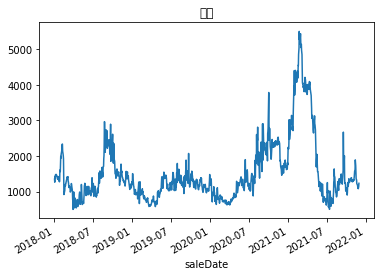

In [44]:
top1_avg.index = pd.to_datetime(top1_avg.index, format=r'%Y%m%d')
top1_avg.plot(title="대파")

In [45]:
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'대파'}, xlabel='saleDate'>

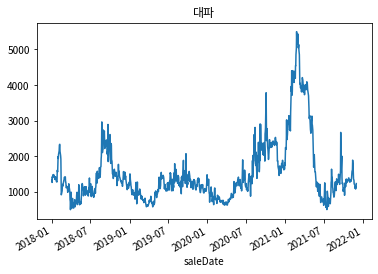

In [56]:
top1_avg.plot(title="대파")

In [57]:
top1_avg

saleDate
2018-01-02    1351.207444
2018-01-03    1267.470944
2018-01-04    1428.275895
2018-01-05    1393.691615
2018-01-06    1470.372035
                 ...     
2021-11-25    1098.040701
2021-11-26    1154.549252
2021-11-27    1083.982814
2021-11-29    1145.418474
2021-11-30    1235.573838
Length: 1220, dtype: float64

In [59]:
top1_arr = top1_avg.to_numpy()

In [65]:
# fix random seed for reproducibility
np.random.seed(1)

In [67]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(top1_arr.reshape([-1,1]))

In [68]:
dataset

array([[0.16976693],
       [0.15300278],
       [0.18519614],
       ...,
       [0.11626822],
       [0.12856772],
       [0.14661694]])

In [69]:
# split into train and test sets
train_size = int(len(dataset) * 0.67) 
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [72]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [73]:
# reshape into X=t and Y=t+1
look_back = 28
trainX, trainY = create_dataset(train, look_back)  
testX, testY = create_dataset(test, look_back)

# reshape input to be  [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0],look_back, 1))

In [74]:
trainX

array([[[0.16976693],
        [0.15300278],
        [0.18519614],
        ...,
        [0.29783925],
        [0.28793436],
        [0.3097527 ]],

       [[0.15300278],
        [0.18519614],
        [0.17827232],
        ...,
        [0.28793436],
        [0.3097527 ],
        [0.31563989]],

       [[0.18519614],
        [0.17827232],
        [0.19362384],
        ...,
        [0.3097527 ],
        [0.31563989],
        [0.33051309]],

       ...,

       [[0.10535128],
        [0.1061424 ],
        [0.14631583],
        ...,
        [0.42082495],
        [0.32153766],
        [0.41004473]],

       [[0.1061424 ],
        [0.14631583],
        [0.17951233],
        ...,
        [0.32153766],
        [0.41004473],
        [0.38747093]],

       [[0.14631583],
        [0.17951233],
        [0.19144301],
        ...,
        [0.41004473],
        [0.38747093],
        [0.46210015]]])

In [78]:
# create and fit the LSTM network

model = Sequential()
model.add(LSTM(4, input_shape=(look_back,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history= model.fit(trainX, trainY,validation_split=0.33, epochs=200, batch_size=32)

# Plot training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.show()

Epoch 1/200


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_3/lstm_3/PartitionedCall]] [Op:__inference_train_function_4086]

Function call stack:
train_function -> train_function -> train_function


In [79]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

RuntimeError: Physical devices cannot be modified after being initialized